# From noise to nuance: Exploring image generative AI models

**Learning goals**

- Explain how latent diffusion models generate images

- Show how to implement unconditional image generation using PyTorch

- Explore the use of HuggingFace for model development and inference
​

**Task**: Unconditional image generation - Task of generating an image without it being conditioned on any additional information, such as labels, text, or other images.

For example, a model trained on understanding patterns of flowers is able to create new flowers that did not exist in its training dataset.

**Data**: *Oxford Flower 102* - 102 flower categories commonly occuring in the United Kingdom. Each class consists of between 40 and 258 images. More information available [here](https://huggingface.co/datasets/nelorth/oxford-flowers) and [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)

**Model**: Latent diffusion,  [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752) (Rombach et al. 2021)

**Framework**: [PyTorch](https://pytorch.org/) - A machine learning framework based on the Torch library, used for creating deep neural networks applications, such as computer vision tasks.

**Hugging Face**: - A company and community that develops computation tools for building applications using machine learning, [info](https://huggingface.co/).

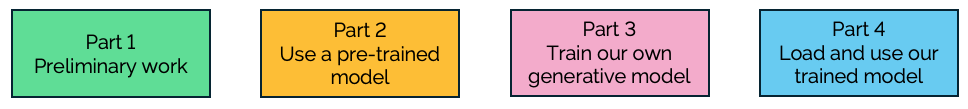

## Part 1. Preliminary work

- Install required libraries
- Check available device (GPU or CPU)

### Install some required libraries

The environment in Google Colab already has some pre-installed libraries useful for this workshop. We will have to additionally install the following:
- [diffusers](https://pypi.org/project/diffusers/): state-of-the-art pretrained diffusion models for generating images, audio, and even 3D structures of molecules
- [datasets](https://pypi.org/project/datasets/): one-liners to download and pre-process any of major public datasets (e.g. image datasets, audio datasets and text datasets)

In [ ]:
! pip install diffusers
! pip install datasets

### Identify the available device


Deep learning models perform thousands of computations and require high speed. GPUs (Graphics Processing Unit) enable multiple, simultaneous computations and speed up the training process. Hence, we need to check if a GPU is available so as to use it, else we proceed with our CPU.

Note:

In the simple examples of the widely used benchmark datasets and simple models training on a CPU might be completed quite quickly. In real-world problems training even on a GPU might require hours or even days. So performing this on a CPU would be inefficient and time-consuming, and could even fail.

In [ ]:

# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

## Part 2. Load a pre-trained model and generate (sample) images

1. Load a pre-trained model for unconditional image generation for the Oxford flower dataset
2. Generate a random image. This image will be of a new flower that was not part of the training dataset used for this model.

**Additional information:**
- Explore other pre-trained models [here](https://huggingface.co/models?library=diffusers&sort=trending)
- We will use a [DiffusionPipeline](https://huggingface.co/docs/diffusers/api/pipelines/overview) from HuggingFace that stores components (models, schedulers, and processors) useful for diffusion pipelines and provides methods for loading, downloading and saving models.

In [ ]:
from diffusers import DiffusionPipeline

# For the Oxford flower dataset use: shahp7575/oxford_flowers_sample_diffused from the hub: https://huggingface.co/models?library=diffusers&sort=trending
generator = DiffusionPipeline.from_pretrained("shahp7575/oxford_flowers_sample_diffused").to(device)
image_from_pretrained = generator().images[0]
image_from_pretrained

In [ ]:
# Check the image size
image_from_pretrained.size

In [ ]:
# Resize the image using PIL
from PIL import Image

# Define the new size
new_size = (128, 128)

# Resize the generated image
resized_image = image_from_pretrained.resize(new_size, Image.LANCZOS)

# Display the resized image
resized_image

## Part 3. How can we train our own diffusion model?

Why would we want to train our own model?

- Customisation: We might have specific requirements or constraints that are not met by pre-trained models
- Data privacy and security: Confidential data
- Domain relevance: Models pre-trained on generic datasets might not perform well in specialised domains (e.g. medical imaging, financial data)
- Educational purposes: Training a model from scratch helps in understanding the intricacies of the underlying algorithms and architectures


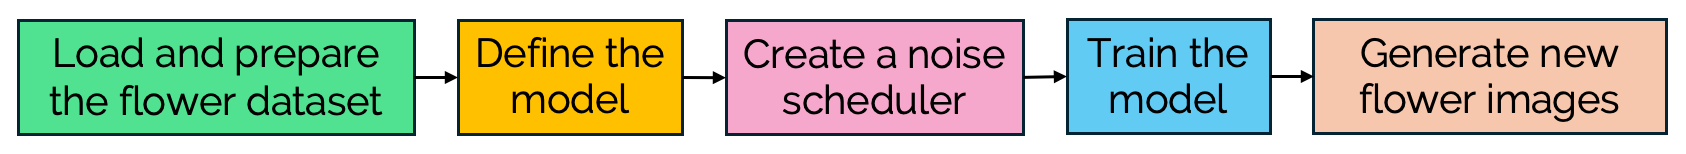

### Part 3a. Load, explore and transform the flower dataset

Load the Oxford flowers dataset from the [Hugging Face dataset hub](https://huggingface.co/datasets).

In [ ]:
from datasets import load_dataset

dataset_name = "nelorth/oxford-flowers"
dataset = load_dataset(dataset_name, split="train")

In [ ]:
# Size of the dataset
len(dataset)

In [ ]:
# Let's look at some samples

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [ ]:
# Size of the images in the dataset.
dataset[3]["image"].size

**Extra points!** Change the selected image and see that you will probably get a different size. So, the image sizes are not consistent.

**Transform the images**

Apply transformations to the images, which are needed for:

*   Consistent input size: Ensures all images have the same size, which is a requirement for most neural networks.
*   Data augmentation: Random horizontal flip increases the variability of the dataset, helping prevent overfitting and improving the model's ability to generalise.
* Tensor conversion: Converts images to the format required by PyTorch models.
* Normalisation: Standardises the pixel values, which can improve model training efficiency and effectiveness.
* Conversion to RGB format for consistency (as some might be in grayscale)

In [ ]:
from torchvision import transforms

# Define a series of transformations to be applied to an input image
preprocess = transforms.Compose(
    [
        transforms.Resize((128, 128)), # Resize the input image to a fixed size of 128x128 pixels
        transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally with a probability of 0.5
        transforms.ToTensor(), # Convert input image into a PyTorch tensor. Also scales the pixel values from the range [0, 255] to [0, 1]
        transforms.Normalize([0.5], [0.5]), # Normalise each channel of the tensor image with mean and standard deviation
    ]
)

# Set the transform function for the dataset
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]] # Ensure each image is converted to RGB format
    return {"images": images} # returns a dictionary, with only one key "images" as Hugging Face's datasets library usually expects datasets to be in dictionary format


dataset.set_transform(transform) # Apply the transform function to each item in the dataset whenever accessed

In [ ]:
# Access items in the dataset and the transform function will be applied. It might require some time.
for item in dataset:
    transformed_images = item["images"]

In [ ]:
# Verify that the transformation has been applied by checking the shape which must now be 128x128 pixels instead of 523x500
dataset[0]["images"].shape

In [ ]:
# View the transformed images
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Function to denormalise the tensor for visualisation, to revert the pixel values back to their original scale and format
def denormalise(tensor, mean, std):
  for t, m, s in zip(tensor, mean, std):
    t.mul_(s).add_(m)
  return torch.clamp(tensor, 0, 1)

# Now, when you access items in the dataset, the transform function will be applied
for i in range(5):
  item = dataset[i]
  transformed_images = item["images"]

  # Denormalise the image tensor for visualisation\n",
  denorm_image = denormalise(transformed_images, [0.5], [0.5])

  # Convert the tensor to a numpy array and transpose to (H, W, C)
  np_image = denorm_image.permute(1, 2, 0).numpy()

  # Plot the image
  plt.imshow(np_image)
  plt.title(f"Image {i+1}")
  plt.axis('off')
  plt.show()

**Create a dataloader from the dataset**

The `torch.dataset` type stores the samples and their corresponding labels (if available). However, while training a model we need to be able to handle it efficiently e.g. iterate over it and split it in batches.

Hence, we convert the Dataset to a Dataloader. DataLoaders are crucial components in PyTorch for efficient and convenient handling of datasets, especially in the context of training deep learning models.
A DataLoader wraps an iterable around the Dataset to enable easy access to the samples and help with the internal processing that happens in PyTorch.

They are useful for: batch processing, shuffling and randomisation, integration with models and customisation.

In [ ]:
# Create a dataloader from the dataset
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 16

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")

In [ ]:
# Check out what's inside the training dataloader by getting a single batch
train_features_batch = next(iter(train_dataloader)) # the batch in this case is a dictionary
train_features_batch['images'].shape

### Part 3b. Define the model

We will be using UNet.

UNet is a special type of neural network designed for segmenting images (deviding them into different regions representing objects or areas of interest).

Key characteristics of UNet:


*   U-shaped symmetric structure with two parts, encoder on the left and decoder on the right.
*   Encoder: Reduces the image size, after capturing its context in feature maps.
*   Bottleneck: The bottom of the U-shape. Here the image representation is the smallest and captures the most abstract features.
*   Decoder up-samples the image back to its original size. Reconstructs the image from the abstract features captured by the encoder.
*   Skip connections: connections directly between the encoder and decoder layers.




In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=128,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a typical ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a typical ResNet upsampling block
        "AttnUpBlock2D",  # ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

### Part 3c. Create a noise scheduler

A noise scheduler is used in the Denoising Diffusion Probabilistic Models (DDPMs) for adjusting the level of noise dynamically over the course of training.

In this part we will instantiate a noise scheduler, create random noise, add noise to an image and visualise it.

In [ ]:
# Extract one image sample (here the first, it can be any)
sample_image = dataset[0]["images"].unsqueeze(0)

In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

# Instantiate a noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) # the total number of training steps or iterations, the duration over which the noise level will be adjusted

# Sample some random noise with shape that of the image
noise = torch.randn(sample_image.shape)

# Create a tensor with one element, the number 50. It has to be a tensor for the add_noise to work properly later.
timesteps = torch.LongTensor([50])


In [ ]:
# Function to convert a PyTorch tensor to a PIL image

def tensor_to_pil_image(tensor):
    """
    Convert a PyTorch tensor to a PIL image
    """
    tensor = tensor.permute(0, 2, 3, 1) # Permute to change the dimensions order as PyTorch: (batch_size, channels, height, width) and expected by PIL: (height, width, channels)
    tensor = ((tensor + 1.0) * 127.5).type(torch.uint8) # Denormalize and convert to uint8
    np_image = tensor.numpy()[0] # Convert to NumPy array and extract the first image in the batch

    return Image.fromarray(np_image) # Convert NumPy array to PIL Image

In [ ]:
# Create and visualise a noisy image

# The higher the number of timesteps the more noisy the image
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps) # tensor of shape (batch_size, channels, height, width)

pil_image = tensor_to_pil_image(noisy_image)
pil_image

**Extra points!** Go back to cell 29 and change the noise value to something high and then something low, re-run cell 32 and look how the noisy image changes!

In [ ]:
noisy_image.shape

### Part 3d: Model training

In this part we will train the model with the following steps:


*   Define the optimiser
*   Define a training configuration
*   Define the training loop
*   Evaluate: Define how to sample images from random noise

**Note:**

The `diffusers` library from Hugging Face operates in the pixel space and not in the latent space.
Advantages: direct manipulation of images, easier to interpret visually operations, compatible with image processing operations available in libraries.
Disadvantages: not abstract representations that capture high-level features, not dimentionality reduction.




In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from dataclasses import dataclass

# Use a decorator, a design pattern that allows you to add functionality to an existing function or class
@dataclass
class TrainingConfig:
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 1 # we set it to train for only 1 epoch for learning purposes
    lr_warmup_steps = 5
    save_image_epochs = 1
    output_dir = "flower_diff"  # folder to save the generated images
    seed = 0


config = TrainingConfig()

**Useful information for the training loop**


For each epoch:
- Initialise a progress bar.
- For each batch of data:
  1. Prepare data: Move images to the device (CPU/GPU) and generate random noise.
  2. Sample timesteps: Randomly select a timestep for each image.
  3. Add noise: Add noise to the images based on the selected timesteps.
  4. Forward pass: Use the model to predict the noise in the noisy images.
  5. Calculate loss: Compute the loss between the predicted noise and the actual noise.
  6. Backward pass: Perform backpropagation to compute gradients.
  7. Clip gradients: Prevent gradients from becoming too large.
  8. Optimisation step: Update model parameters using the optimizer.
  9. Update scheduler: Adjust learning rate using the scheduler.
  10. Log progress: Update progress bar and log loss and learning rate.

**Evaluation and saving:**

After each epoch, optionally:
- Generate and save sample images.
- Save the model checkpoint. It saves the model weights, configurations, and any other necessary files required to reload the pipeline later.

In [ ]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import os
from diffusers import DDPMPipeline
from safetensors.torch import load_file, save_file

def train_loop(config, device, model, noise_scheduler, optimizer, train_dataloader):
    model = model.to(device)

    # Create output directory if specified
    if config.output_dir is not None:
        os.makedirs(config.output_dir, exist_ok=True)

    global_step = 0  # Track the global step for logging

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        train_loss = 0

        for step, batch in enumerate(train_dataloader):
            # Get the original-transformed/clean images for the current batch
            clean_images = batch["images"].to(device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=device)
            batch_size = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # 1. Forward pass - calculation of the values of the output layers from the input data
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            # 2. Calculate loss (per batch)
            loss = F.mse_loss(noise_pred, noise)
            train_loss += loss.item()  # accumulate the loss per epoch

            # 3. For the Optimizer set gradients of all model parameters to zero
            optimizer.zero_grad()

            # 4. Loss backward - backpropagation (computes dloss/dx for every parameter)
            loss.backward()

            # Clip gradients to prevent explosion (exceed a specified threshold, here 1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 5. Optimizer step (performs a single optimization step - parameter update)
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": epoch * len(train_dataloader) + step}
            progress_bar.set_postfix(**logs)
            global_step += 1  # Increment global step

        progress_bar.close()

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if config.output_dir is not None:
          pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
          evaluate(config, epoch, pipeline)
          pipeline.save_pretrained(f"{config.output_dir}{epoch:04d}.pt") # Save the pipeline/model

In [ ]:
# DON'T RUN THIS YET - WE WILL RUN IT TOGETHER LATER

# Call training loop without accelerator, it requires a lot of time even for one epoch

train_loop(config, device, model, noise_scheduler, optimizer, train_dataloader)

Show the latest image created during the evaluation process

In [ ]:
# Use the Python package glob to find pathnames matching a specified pattern
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

### Part 4: Load the trained model

As training diffusion models requires a lot of time and computational power, we have trained the model using an NVIDIA GPU Quadro RTX. We used 100 epochs, with images with resolution 128x128 and the training time was 5 hours.
Training with same training parameters but for images of size 64x64 run for 2 hours, due to decreased complexity.

In [ ]:
# Load the weights from the model that we have pre-trained using resolution 128x128
!gdown --folder https://drive.google.com/drive/folders/1vlB4SymqBrkq1XP3Hf3tVcgcL03qwStt?usp=sharing

In [ ]:
# Load the weights from the model that we have pre-trained using resolution 64x64
!gdown --folder https://drive.google.com/drive/folders/1VChD7jSWmwxP8I4SSsn8D9C4DV_zy52p?usp=sharing

In [ ]:
# Alternate loading the two models from the local directory
# and look at the generated images.
# What do you notice?
generator = DiffusionPipeline.from_pretrained("./oxford_flowers_100_128_0099.pt").to("cuda" if torch.cuda.is_available() else "cpu")

# Generate an image using the pipeline
image = generator().images[0]

image


**Extra points!** Print the size of the generated image

**Extra points!** Use the pre-trained model with resolution 64x64 and generate an image! Which one do you prefer?

## Further improvements, additional steps and point to consider
- Improve the config class with all pre-defined variables of the script, e.g. add batch size and number of epochs or create a config file
- Use a learning rate scheduler which is often a good practice, especially for complex models like diffusion models. It can lead to better training performance and model convergence.
- Use Hugging Face `Accelerator` to simplify the process of training and optimising ML models.
- Train the models for more epochs.

### References:

This workshop was based on [HuggingFace Diffusers - Train a diffusion model](https://huggingface.co/docs/diffusers/en/tutorials/basic_training) under the Apache-2.0 license
